CFL number: 0.30000000000000004
True position: (15, 15)
Estimated position: (50.00, 50.00)
Estimation error: 49.50 units
Initial field max: 1.0
Final field max: 10.613176990597752
Arrival times: [0.45 0.45 0.45 0.45]
Peak intensities: [1.06131770e+01 5.29614937e-10 5.29614937e-10 2.25314299e-20]


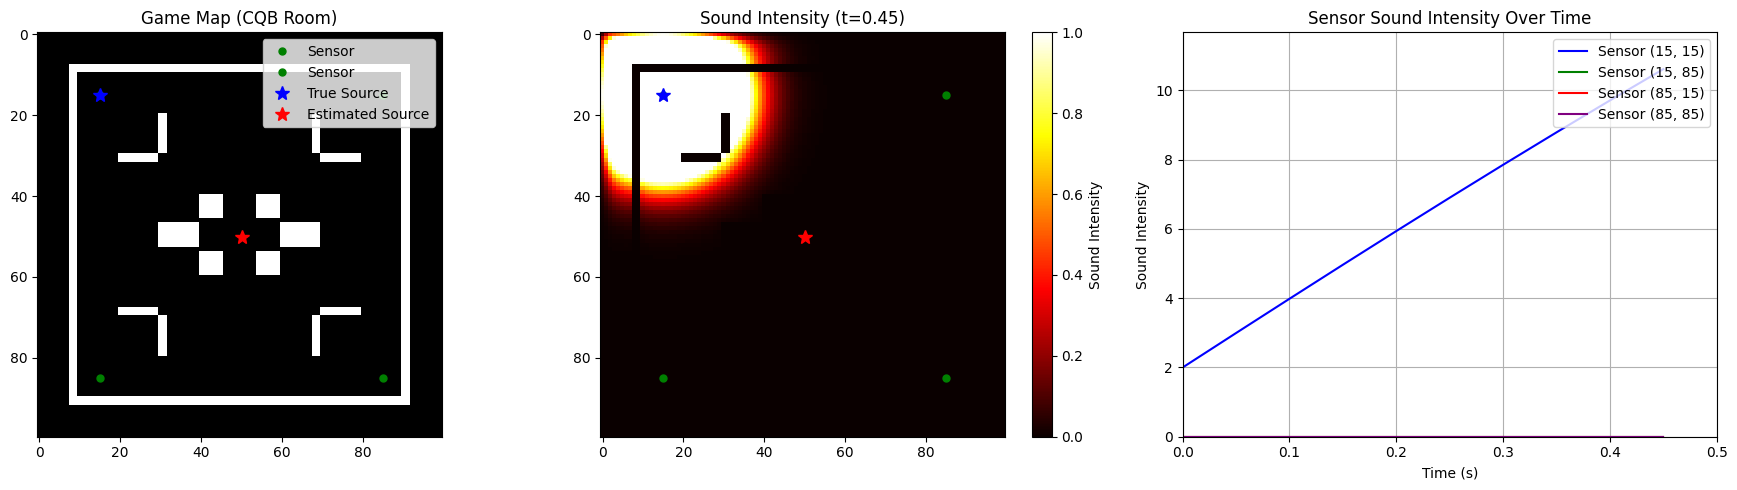

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import least_squares
from scipy.ndimage import laplace
from IPython.display import HTML

# 설정
SIZE = 100
dx = 0.5
dt = 0.05
c = 3.0
gamma = 0.0
steps = 10

# CFL 확인
courant = c * dt / dx
print(f"CFL number: {courant}")
if courant > 1 / np.sqrt(2):
    print("Warning: CFL condition may be violated, simulation could be unstable!")

# 파동 필드 초기화
u = np.zeros((SIZE, SIZE))
u_prev = np.zeros((SIZE, SIZE))
u_next = np.zeros((SIZE, SIZE))

# CQB 맵 설정
game_map = np.zeros((SIZE, SIZE))
game_map[8:92, 8:10] = 1
game_map[8:92, 90:92] = 1
game_map[8:10, 8:92] = 1
game_map[90:92, 8:92] = 1
game_map[40:46, 40:46] = 1
game_map[40:46, 54:60] = 1
game_map[54:60, 40:46] = 1
game_map[54:60, 54:60] = 1
game_map[30:32, 20:30] = 1
game_map[30:32, 70:80] = 1
game_map[68:70, 20:30] = 1
game_map[68:70, 70:80] = 1
game_map[20:30, 30:32] = 1
game_map[20:30, 68:70] = 1
game_map[70:80, 30:32] = 1
game_map[70:80, 68:70] = 1
game_map[47:53, 30:70] = 1
game_map[47:53, 40:60] = 0

# 파동 속도 맵
c_map = np.ones((SIZE, SIZE)) * c
wall_indices = np.where(game_map == 1)
for i, j in zip(wall_indices[0], wall_indices[1]):
    c_map[i, j] = 0
    for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < SIZE and 0 <= nj < SIZE:
            c_map[ni, nj] = 0

# 소리 소스 위치
source_x, source_y = 15, 15

# 초기 조건: 가우시안 펄스
x, y = np.meshgrid(np.arange(SIZE), np.arange(SIZE))
sigma = 10.0
u = np.exp(-((x - source_x)**2 + (y - source_y)**2) / (2 * sigma**2))
u_prev = np.zeros_like(u)

# 센서 위치
sensors = [(15, 15), (15, 85), (85, 15), (85, 85)]

# 센서 강도, 도착 시간, 파동 필드 저장
sensor_intensities = [[] for _ in sensors]
arrival_times = np.full(len(sensors), np.inf)
peak_intensities = np.zeros(len(sensors))  # 피크 강도 저장
u_frames = [u.copy()]

# Mur 계수
coef = (courant - 1) / (courant + 1)

# 시뮬레이션 루프
for t in range(steps):
    laplacian = laplace(u, mode='constant') / dx**2
    u_next = (2 * u - u_prev + (c_map * dt)**2 * laplacian - gamma * dt * (u - u_prev)) / (1 + gamma * dt)
    
    u_next[0, :] = u_prev[1, :] + coef * (u_next[1, :] - u_prev[0, :])
    u_next[-1, :] = u_prev[-2, :] + coef * (u_next[-2, :] - u_prev[-1, :])
    u_next[:, 0] = u_prev[:, 1] + coef * (u_next[:, 1] - u_prev[:, 0])
    u_next[:, -1] = u_prev[:, -2] + coef * (u_next[:, -2] - u_prev[:, -1])
    
    u_next[game_map == 1] = 0
    
    u_prev = u.copy()
    u = u_next.copy()
    
    # 센서 강도 기록
    for idx, (sx, sy) in enumerate(sensors):
        intensity = np.abs(u[sy, sx])
        sensor_intensities[idx].append(intensity)
        if intensity > peak_intensities[idx]:
            peak_intensities[idx] = intensity
            arrival_times[idx] = t * dt
    
    u_frames.append(u.copy())

# 위치 추정 함수 (가중 최소제곱법)
def residuals(pos, weights):
    est_x, est_y = pos
    res = []
    ref_time = arrival_times[0]
    for i in range(1, len(sensors)):
        if np.isfinite(arrival_times[i]):
            dx1, dy1 = est_x - sensors[0][0], est_y - sensors[0][1]
            dx2, dy2 = est_x - sensors[i][0], est_y - sensors[i][1]
            dist1 = np.sqrt(dx1**2 + dy1**2)
            dist2 = np.sqrt(dx2**2 + dy2**2)
            tdoa = arrival_times[i] - ref_time
            res.append(weights[i] * (dist2 - dist1 - c * tdoa))
    return res

# 다중 초기 추정치로 위치 추정
if np.sum(np.isfinite(arrival_times)) >= 3:
    # 가중치: 피크 강도 정규화
    weights = peak_intensities / np.max(peak_intensities)
    weights[0] = 1.0  # 기준 센서 가중치
    # 초기 추정치 후보: 센서 쌍 중점과 맵 중앙
    initial_guesses = [
        [np.mean([s[0] for s in sensors]), np.mean([s[1] for s in sensors])],  # 센서 평균
        [(sensors[0][0] + sensors[1][0]) / 2, (sensors[0][1] + sensors[1][1]) / 2],  # 센서 0-1 중점
        [(sensors[2][0] + sensors[3][0]) / 2, (sensors[2][1] + sensors[3][1]) / 2],  # 센서 2-3 중점
        [SIZE / 2, SIZE / 2]  # 맵 중앙
    ]
    best_result = None
    best_cost = np.inf
    for guess in initial_guesses:
        result = least_squares(lambda pos: residuals(pos, weights), guess)
        if result.success and 0 <= result.x[0] < SIZE and 0 <= result.x[1] < SIZE:
            if result.cost < best_cost:
                best_cost = result.cost
                best_result = result
    if best_result:
        estimated_pos = best_result.x
        error = np.sqrt((estimated_pos[0] - source_x)**2 + (estimated_pos[1] - source_y)**2)
        print(f"True position: ({source_x}, {source_y})")
        print(f"Estimated position: ({estimated_pos[0]:.2f}, {estimated_pos[1]:.2f})")
        print(f"Estimation error: {error:.2f} units")
    else:
        print("Position estimation failed or out of bounds.")
else:
    print("Insufficient sensor detections for estimation.")

# 디버깅
print(f"Initial field max: {np.max(np.abs(u_frames[0]))}")
print(f"Final field max: {np.max(np.abs(u_frames[-1]))}")
print(f"Arrival times: {arrival_times}")
print(f"Peak intensities: {peak_intensities}")

# 시각화 설정 (3개의 서브플롯)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 왼쪽: 게임 맵
ax[0].imshow(game_map, cmap='gray')
ax[0].set_title('Game Map (CQB Room)')
for sx, sy in sensors:
    ax[0].plot(sx, sy, 'go', markersize=5, label='Sensor' if sx == sensors[0][0] else "")
ax[0].plot(source_x, source_y, 'b*', markersize=10, label='True Source')
if 'estimated_pos' in locals():
    ax[0].plot(estimated_pos[0], estimated_pos[1], 'r*', markersize=10, label='Estimated Source')
ax[0].legend(loc='upper right')

# 중앙: 소리 강도 히트맵
im = ax[1].imshow(np.abs(u_frames[0]), cmap='hot', vmin=0, vmax=np.max(np.abs(u_frames[0])))
ax[1].set_title('Sound Intensity (t=0.0)')
for sx, sy in sensors:
    ax[1].plot(sx, sy, 'go', markersize=5)
ax[1].plot(source_x, source_y, 'b*', markersize=10)
if 'estimated_pos' in locals():
    ax[1].plot(estimated_pos[0], estimated_pos[1], 'r*', markersize=10)
plt.colorbar(im, ax=ax[1], label='Sound Intensity')

# 오른쪽: 센서 강도 그래프
time_axis = np.arange(steps) * dt
lines = []
colors = ['blue', 'green', 'red', 'purple']
for idx, (sx, sy) in enumerate(sensors):
    line, = ax[2].plot([], [], color=colors[idx], label=f'Sensor ({sx}, {sy})')
    lines.append(line)
ax[2].set_title('Sensor Sound Intensity Over Time')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Sound Intensity')
ax[2].set_xlim(0, steps * dt)
max_intensity = max([max(intens) for intens in sensor_intensities if intens]) if any(sensor_intensities) else 1
ax[2].set_ylim(0, max_intensity * 1.1)
ax[2].legend(loc='upper right')
ax[2].grid(True)

plt.tight_layout()

# 애니메이션 업데이트 함수
def update(frame):
    im.set_array(np.abs(u_frames[frame]))
    ax[1].set_title(f'Sound Intensity (t={frame*dt:.2f})')
    for idx, line in enumerate(lines):
        line.set_data(time_axis[:frame+1], sensor_intensities[idx][:frame+1])
    return [im] + lines

# 애니메이션 생성
ani = FuncAnimation(fig, update, frames=steps, interval=10, blit=True)

# Jupyter/IPython에서 애니메이션 표시
HTML(ani.to_jshtml())

# 필요 시 저장
# ani.save('sound_and_sensor_animation_improved.mp4', writer='ffmpeg', fps=50)